In [4]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# load modules related to this exercise
from DurableConsumptionModel import DurableConsumptionModelClass 
import estimate
import estimate_old

import numba as nb
nb.set_num_threads(4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model

In [7]:
model = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','do_print':True})
model.precompile_numba() # solve with very coarse grids
model.solve()
model.simulate()

par = model.par
sol = model.sol
sim = model.sim

numba precompiled in 46.0 secs
 t = 29 solved in 0.0 secs
  w computed in 12.9 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 28 solved in 13.1 secs
  w computed in 10.5 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 27 solved in 23.7 secs
  w computed in 10.7 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 26 solved in 34.6 secs
  w computed in 10.6 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 25 solved in 45.4 secs
  w computed in 10.6 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 24 solved in 56.1 secs
  w computed in 10.8 secs
  solved keeper problem in 0.1 secs
  solved adjuster problem in 0.0 secs
 t = 23 solved in 67.0 secs
  w computed in 10.2 secs


Traceback (most recent call last):
  File "c:\Users\signe\OneDrive - University of Copenhagen\Documents\Polit10\DP\term paper\dp2022\two_asset\DurableConsumptionModel.py", line 309, in solve
    assert np.all((sol.q[t] > 0) & (np.isnan(sol.q[t]) == False)), t
AssertionError: 22


AssertionError: 22

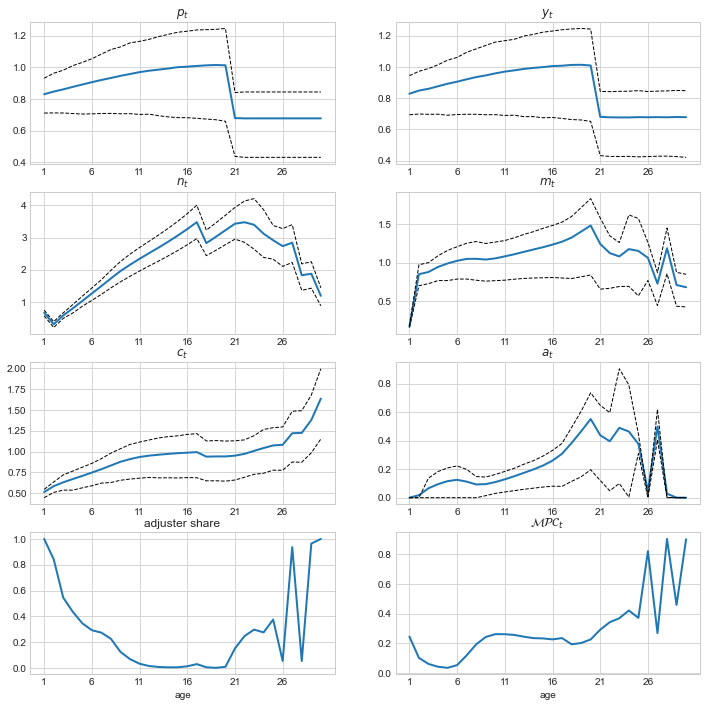

In [3]:
model.lifecycle(deciles=False)

## Data

In [5]:
# read data from statistikbanken
y_pd = pd.read_excel('y.xlsx',sheet_name='y',header=0)
a_pd = pd.read_excel('a.xlsx',sheet_name='a',header=0)

#interpolating between age intervals
y_interp = y_pd.interpolate(method='linear',axis=0)
a_interp = a_pd.interpolate(method='linear',axis=0)

#dropping unnecessary rows/cols
a_interp = a_interp.drop(labels=[0,1,2,3,4,5,6],axis=0) #dropping years 18-24

y_interp = y_interp.drop(y_interp.columns[[0]],axis=1) #dropping age column
a_interp = a_interp.drop(a_interp.columns[[0]],axis=1) #dropping age column

#to np array
y = y_interp.to_numpy()
a = a_interp.to_numpy()

# meaning over years
mean_y_data = np.mean(y,axis=1)
mean_a_data = np.mean(a,axis=1)

# reshape
mean_y_data = np.reshape(mean_y_data,(56,1))
mean_a_data = np.reshape(mean_a_data,(56,1))

# join into one 56x2 array
mean_data = np.append(mean_y_data,mean_a_data,axis=1)
mean_data_small = mean_data[:30,:]



## MOMENTS USING MEAN FOR a AND y

In [4]:
# save true parameters
par_beta = copy.copy(par.beta)
par_rho = copy.copy(par.rho)

# data / empirical moments
data = copy.copy(sim)
#data.moments = estimate.calc_moments(par,data)   # replace this with 
#model.par.scale = xxx
data.moments = mean_data_small.T  # replace this with 

# scaling
scale_y = mean_data[:,0].mean()/model.sim.y.mean()

print(data.moments.shape)

(2, 30)


In [5]:
data.moments

array([[ 2.56147654e-03,  1.81112923e-02,  6.79765477e-02,
         9.45755597e-02,  1.14948160e-01,  1.27327849e-01,
         1.13170836e-01,  9.55028058e-02,  9.50509414e-02,
         1.10880533e-01,  1.27423032e-01,  1.50154961e-01,
         1.75239403e-01,  1.98713451e-01,  2.25657766e-01,
         2.59748834e-01,  3.05619717e-01,  3.81730070e-01,
         4.67825471e-01,  5.50655298e-01,  4.39529379e-01,
         3.94471677e-01,  4.90284591e-01,  4.62919930e-01,
         3.78820674e-01,  4.50544273e-02,  5.00329847e-01,
         2.76721243e-02, -1.70567101e-03, -3.37942853e-04],
       [ 8.28875342e-01,  8.49180256e-01,  8.57236579e-01,
         8.75434549e-01,  8.95089252e-01,  9.04910341e-01,
         9.21350767e-01,  9.33635348e-01,  9.45718757e-01,
         9.57835400e-01,  9.69158481e-01,  9.78692875e-01,
         9.86847306e-01,  9.95722323e-01,  9.99161730e-01,
         1.00587584e+00,  1.00836232e+00,  1.01227588e+00,
         1.01093171e+00,  1.00999511e+00,  6.81835982e-

In [6]:
Nbeta = 2
Nrho = 2

obj = np.nan + np.zeros((Nbeta,Nrho))
beta = np.linspace(0.955,0.975,Nbeta)
rho = np.linspace(1.5,2.5,Nrho)

count = 1
for i in range(Nbeta):
    for j in range(Nrho):
        print(f"{count} / {Nbeta*Nrho}")
        est_par = ['beta','rho']
        theta0 = [beta[i], rho[j]]
        obj[i,j]=estimate.sum_squared_diff_moments(theta0,model,est_par,data)
        count += 1


1 / 4
Mean of moments:  [[ 2.54590206e-03  1.98340779e-02  7.97870663e-02  9.93613999e-02
   1.13822254e-01  1.04032878e-01  8.28376782e-02  7.12525950e-02
   7.00594070e-02  7.74560220e-02  8.20851048e-02  9.16007258e-02
   1.03663938e-01  1.14178351e-01  1.28650374e-01  1.50720548e-01
   1.85510514e-01  2.59076955e-01  3.48530824e-01  4.41649459e-01
   3.66873454e-01  3.50878914e-01  4.36167813e-01  4.09534647e-01
   3.53085305e-01  4.43414315e-02  4.89799396e-01  2.03719026e-02
  -1.85490448e-03 -3.37942853e-04]
 [ 8.28875342e-01  8.49180256e-01  8.57236579e-01  8.75434549e-01
   8.95089252e-01  9.04910341e-01  9.21350767e-01  9.33635348e-01
   9.45718757e-01  9.57835400e-01  9.69158481e-01  9.78692875e-01
   9.86847306e-01  9.95722323e-01  9.99161730e-01  1.00587584e+00
   1.00836232e+00  1.01227588e+00  1.01093171e+00  1.00999511e+00
   6.81835982e-01  6.76335210e-01  6.76695721e-01  6.77127444e-01
   6.79557204e-01  6.78886867e-01  6.76847434e-01  6.77748260e-01
   6.78448943e-01

/var/folders/d8/k9yj32vx0_76gfhvj06fhzzw0000gn/T/ipykernel_33516/2295316607.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(surf, shrink=0.5, aspect=5)


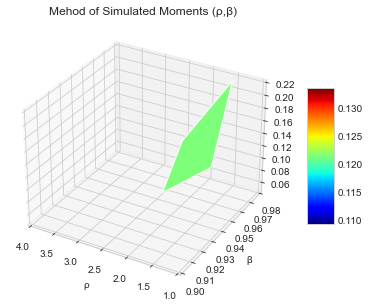

In [7]:
#Plot figure in three dimensions

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d')

# Make data.
X, Y = np.meshgrid(rho, beta)

# Plot the surface.
surf = ax.plot_surface(X, Y, obj, cmap=cm.jet)

# Customize the axis.
ax.set_xlabel(f'\u03C1')
ax.set_ylabel(f'\u03B2')
ax.set_title(f'Mehod of Simulated Moments (\u03C1,\u03B2)')
ax.set_xlim(1.0,4.0)
#ax.set_xlim(1.0,6.0)
ax.set_ylim(0.9,0.98)
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show();

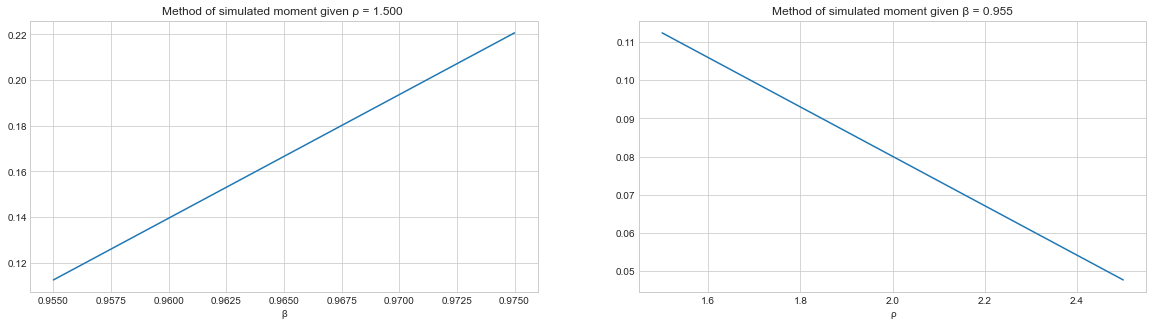

In [8]:
# Plot figure in two dimensions
i_rho = abs(par_rho - rho).argmin(0) #index of rho closest to true rho
i_beta = abs(par_beta - beta).argmin(0) #index of beta closest to true beta


fig = plt.figure(figsize=(20,5))# figsize is in inches...

ax = fig.add_subplot(1,2,1)
ax.plot(beta,obj[:,i_rho])
ax.set_xlabel(f'\u03B2')
ax.set_title(f'Method of simulated moment given \u03C1 = {rho[i_rho]:.3f} ')

ax = fig.add_subplot(1,2,2)
ax.plot(rho,obj[i_beta,:])
ax.set_xlabel(f'\u03C1')
ax.set_title(f'Method of simulated moment given \u03B2 = {beta[i_beta]:.3f}')


plt.show()

## Rest of notebook

In [27]:
est_par = ['beta'] # Parameter to estimate
theta0 = [0.94] # Initial guess

est = estimate.method_simulated_moments(model, est_par,theta0,data)

#Re-inset the true parameters 
par.beta = copy.copy(par_beta)

print(f'Objective:               {est.fun:.4f}')
print(f'beta:                    {est.x[0]:.4f}')
print(f'Number of iterations:    {est.nit}')


Traceback (most recent call last):
  File "/Users/frederikp/OneDrive - University of Copenhagen/Kandidat/Dynamic Programming/dp2022/praise_the_lord/DurableConsumptionModel.py", line 300, in solve
    post_decision.compute_wq(t,sol,par,compute_q=True)
KeyboardInterrupt


KeyboardInterrupt: 

In [11]:
est_par = ['rho'] # Parameter to estimate
theta0 = [2.5] # Initial guess

est = estimate.method_simulated_moments(model, est_par,theta0,data)

#Re-inset the true parameters 
par.rho = copy.copy(par_rho)

print(f'Objective:               {est.fun:.4f}')
print(f'rho:                     {est.x[0]:.4f}')
print(f'Number of iterartions:   {est.nit}')


Objective:               0.0420
rho:                     3.5721
Number of iterartions:   3


In [19]:
est_par = ['rho','beta'] # Parameters to estimate
theta0 = [4, 0.94] # Initial guesses

est = estimate.method_simulated_moments(model, est_par,theta0,data)

#Re-inset the true parameters 
par.beta = copy.copy(par_beta)
par.rho = copy.copy(par_rho)

print(f'Objective:               {est.fun:.4f}')
print(f'rho:                     {est.x[0]:.4f}')
print(f'beta:                    {est.x[1]:.4f}')
print(f'Number of iterartions:   {est.nit}')


Traceback (most recent call last):
  File "/Users/frederikp/OneDrive - University of Copenhagen/Kandidat/Dynamic Programming/dp2022/praise_the_lord/DurableConsumptionModel.py", line 298, in solve
    post_decision.compute_wq(t,sol,par,compute_q=True)
KeyboardInterrupt


KeyboardInterrupt: 

In [25]:
print(sol.c_keep)

[[[[0.00000000e+00 7.52277641e-03 1.25578236e-02 ... 5.88029677e-01
    6.04148591e-01 6.22278930e-01]
   [0.00000000e+00 9.63427940e-03 1.31550486e-02 ... 5.21084873e-01
    5.35308389e-01 5.51384575e-01]
   [0.00000000e+00 1.08564001e-02 1.44200450e-02 ... 4.99850422e-01
    5.13376724e-01 5.28812351e-01]
   ...
   [0.00000000e+00 6.37971512e-02 8.66043861e-02 ... 4.76802959e-01
    4.87017793e-01 4.98755681e-01]
   [0.00000000e+00 6.37971512e-02 8.99047165e-02 ... 4.79185517e-01
    4.89354122e-01 5.01077165e-01]
   [0.00000000e+00 6.37971512e-02 9.36833292e-02 ... 4.81912449e-01
    4.92130130e-01 5.03728006e-01]]

  [[0.00000000e+00 4.60810525e-02 5.81236948e-02 ... 6.63206118e-01
    6.79318421e-01 6.97934440e-01]
   [0.00000000e+00 4.72291869e-02 5.60625283e-02 ... 5.87526374e-01
    6.01819245e-01 6.18294714e-01]
   [0.00000000e+00 4.97980459e-02 5.68393941e-02 ... 5.63328276e-01
    5.77011334e-01 5.92759688e-01]
   ...
   [0.00000000e+00 6.37971512e-02 1.27899179e-01 ... 5.26

In [27]:
par.grid_m

array([ 0.        ,  0.06379715,  0.12789918,  0.19231027,  0.25703472,
        0.32207692,  0.38744135,  0.45313264,  0.51915549,  0.58551474,
        0.65221536,  0.71926241,  0.78666111,  0.85441682,  0.92253501,
        0.99102132,  1.05988153,  1.12912158,  1.19874757,  1.26876577,
        1.33918263,  1.41000478,  1.48123903,  1.5528924 ,  1.62497212,
        1.69748562,  1.77044057,  1.84384486,  1.91770663,  1.99203428,
        2.06683648,  2.14212217,  2.21790057,  2.29418124,  2.37097404,
        2.44828915,  2.52613714,  2.60452891,  2.6834758 ,  2.7629895 ,
        2.84308218,  2.92376644,  3.00505536,  3.08696254,  3.16950209,
        3.25268869,  3.33653764,  3.42106484,  3.50628688,  3.59222105,
        3.67888541,  3.7662988 ,  3.85448094,  3.94345244,  4.03323491,
        4.12385097,  4.21532437,  4.30768007,  4.4009443 ,  4.49514466,
        4.59031024,  4.68647175,  4.78366163,  4.88191419,  4.98126578,
        5.08175497,  5.18342275,  5.28631276,  5.39047151,  5.49